In [146]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyro.distributions as dist

import pydrake
from pydrake.all import (
    Quaternion,
    RotationMatrix,
    RollPitchYaw
)

from spatial_scene_grammars.rules import WorldFrameBinghamRotationRule
from spatial_scene_grammars.nodes import *

torch.set_default_tensor_type(torch.DoubleTensor)

Bingam Distribution for quaternions $q$:

- $M$ = 4x4 orthogonal orientation
- $Z$ = 4x4 diagonal concentration

$$p(q) = \dfrac{1}{C(Z)} e^{ \text{tr } Z M^T q q^T M}$$

In [148]:
dists = {
    "spread_1": BinghamDistribution(
        param_m=torch.eye(4),
        param_z=torch.tensor([-10, -10, -10, 0.])
    ),
    "tight_2": BinghamDistribution(
        param_m=torch.eye(4),
        param_z=torch.tensor([-1000, -10, -10, 0.])
    ),
    "tight": BinghamDistribution(
        param_m=torch.eye(4),
        param_z=torch.tensor([-1000, -1000, -1000, 0.])
    ),
}
dists = dict()
dists["custom_1"] = WorldFrameBinghamRotationRule.from_rotation_and_rpy_variances(
    RotationMatrix(rpy=RollPitchYaw([0., 0., np.pi/2.])), [100, 100, 1]
)._bingham_dist

datas = {}
for name, dist in dists.items():
    datas[name] = dist.sample(sample_shape=(500,))
    print(RollPitchYaw(Quaternion(datas[name][-1])).vector())

[-0.07685882 -0.04857706 -2.27882573]


<IPython.core.display.Javascript object>


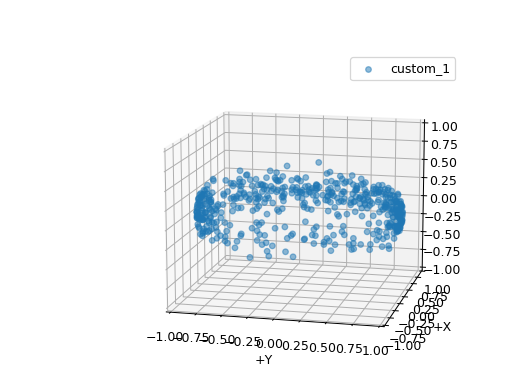

In [149]:
%matplotlib notebook

def draw_data(name, data, ax):
    # Rotate +x by data to get a view into these points on the 3D sphere
    tfd_vecs = []
    vec = np.array([1., 0., 0.])
    for q in data:
        tfd_vecs.append(RotationMatrix(quaternion=Quaternion(q)).multiply(vec))
    tfd_vecs = np.stack(tfd_vecs)

    ax.scatter(tfd_vecs[:, 0], tfd_vecs[:, 1], tfd_vecs[:, 2], label=name, alpha=0.5)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for name, data in datas.items():
    draw_data(name, data, ax)

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
plt.xlabel("+Y")
plt.ylabel("+X")
plt.legend()
plt.show()